### 隨機森林進行選股回測 - 以財報資料處理

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
import datetime
from pandas.tseries.offsets import BMonthEnd
from pandas.tseries.offsets import MonthEnd

> 將日期往前挪到最近一次的工作天(因為有些財報會在星期天發布，需要做調整)

In [2]:
def move_to_nearest_working_day(date):
    if pd.isna(date):
        return date
    # 將日期轉換為 numpy datetime64[D] 格式
    date = np.datetime64(date, 'D')
    # 如果日期是工作天，則不改變
    if date.astype('datetime64[D]').astype('int') % 7 < 5:  # 確認是否為週一至週五
        return date
    else:
        # 如果是週六或週日，調整到最近的工作日（通常向前到週五）
        return np.busday_offset(date, 0, roll='backward')


#### Step1.先讀取每日報酬率(已轉換成累積一季的結果)

In [3]:
Ret_DataFrame = pd.read_pickle('每季報酬(上下市公司_日表示).pkl')
Ret_DataFrame

,證券代碼,年月日,報酬率
0,1101 台泥,2011-09-23,-0.260025
1,1102 亞泥,2011-09-23,-0.214933
2,1103 嘉泥,2011-09-23,-0.101546
3,1104 環泥,2011-09-23,-0.162659
4,1108 幸福,2011-09-23,-0.133519
...,...,...,...
2442803,9944 新麗,2024-06-28,0.117580
2442804,9945 潤泰新,2024-06-28,0.229907
2442805,9946 三發地產,2024-06-28,0.574716
2442806,9955 佳龍,2024-06-28,0.264187


> 記得轉換日期，把ret_date整理成方便閱讀

In [4]:
Ret_DataFrame['年月日'] = pd.to_datetime(Ret_DataFrame['年月日'],format='%Y-%m-%d')
Ret_DataFrame

,證券代碼,年月日,報酬率
0,1101 台泥,2011-09-23,-0.260025
1,1102 亞泥,2011-09-23,-0.214933
2,1103 嘉泥,2011-09-23,-0.101546
3,1104 環泥,2011-09-23,-0.162659
4,1108 幸福,2011-09-23,-0.133519
...,...,...,...
2442803,9944 新麗,2024-06-28,0.117580
2442804,9945 潤泰新,2024-06-28,0.229907
2442805,9946 三發地產,2024-06-28,0.574716
2442806,9955 佳龍,2024-06-28,0.264187


#### Step2.讀取財報資訊(Tej直接下載全部的財報資訊成txt檔案)
> 這次選擇所有上市、下市公司進行分析

In [5]:
Finance_DataFrame = pd.read_pickle('財報資料.pkl')
Finance_DataFrame

,公司,年/月,財報發布日,現金及約當現金,透過損益按公允價值衡量之金融資產－流動,透過其他綜合損益按公允價值衡量之金融資產－流動,按攤銷後成本衡量之金融資產－流動,避險之金融資產－流動,合約資產－流動,應收帳款及票據,...,平均售貨天數,固定資產週轉次數,淨值週轉率（次）,應付帳款付現天數,淨營業週期（日）,季底收款天數,季底售貨天數,自由現金流量(D),季底應收帳款/營收TSE,季底存貨/營收TSE
272,1101 台泥,2013/03,2013/05/15,18994984,271687,15066125,0,6836,0,18645075,...,44.07,0.22,0.17,36.72,79.32,-,-,5306821,77.32,44.31
1094,1101 台泥,2013/06,2013/08/14,20171167,275130,13111745,0,8208,0,20128386,...,42,0.26,0.2,37.4,66.14,-,-,7558212,70.21,36.94
1935,1101 台泥,2013/09,2013/11/14,19104057,219373,14829149,0,0,0,23125217,...,40.95,0.27,0.21,36.03,70.29,-,-,11238111,76.81,33.74
2760,1101 台泥,2013/12,2014/03/31,25711065,215182,19165866,0,11810,0,25597371,...,33.79,0.3,0.22,29.2,71.35,-,-,-8460685,77.08,27.96
3624,1101 台泥,2014/03,2014/05/15,29329415,176175,21266329,0,6895,0,22735014,...,41.53,0.25,0.17,37.9,85.94,-,-,3183392,85.1,39.89
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36997,9958 世紀鋼,2023/06,2023/08/11,2278106,0,0,1934955,0,5040202,1124859,...,47.51,0.22,0.31,64.15,9.07,-,-,-551116,34.95,51.26
37941,9958 世紀鋼,2023/09,2023/11/13,1608540,915,0,2284558,0,5459330,1295775,...,52.57,0.23,0.33,72.38,10.41,-,-,-532781,35.55,49.07
38889,9958 世紀鋼,2023/12,2024/03/08,2000598,0,0,2257300,0,6373009,1531038,...,38.38,0.31,0.4,59.87,4.36,-,-,-1304969,30.77,28.01
39836,9958 世紀鋼,2024/03,2024/05/14,1887925,1405,0,1199052,0,7105701,1084713,...,61.58,0.19,0.21,97.49,1.89,-,-,1055946,34.45,39.98


> 依照"證券代碼"、"年月"進行排序比較好看

In [6]:
Finance_DataFrame = Finance_DataFrame.sort_values(by=["公司", "年/月"], ascending=[True, True])
Finance_DataFrame

,公司,年/月,財報發布日,現金及約當現金,透過損益按公允價值衡量之金融資產－流動,透過其他綜合損益按公允價值衡量之金融資產－流動,按攤銷後成本衡量之金融資產－流動,避險之金融資產－流動,合約資產－流動,應收帳款及票據,...,平均售貨天數,固定資產週轉次數,淨值週轉率（次）,應付帳款付現天數,淨營業週期（日）,季底收款天數,季底售貨天數,自由現金流量(D),季底應收帳款/營收TSE,季底存貨/營收TSE
272,1101 台泥,2013/03,2013/05/15,18994984,271687,15066125,0,6836,0,18645075,...,44.07,0.22,0.17,36.72,79.32,-,-,5306821,77.32,44.31
1094,1101 台泥,2013/06,2013/08/14,20171167,275130,13111745,0,8208,0,20128386,...,42,0.26,0.2,37.4,66.14,-,-,7558212,70.21,36.94
1935,1101 台泥,2013/09,2013/11/14,19104057,219373,14829149,0,0,0,23125217,...,40.95,0.27,0.21,36.03,70.29,-,-,11238111,76.81,33.74
2760,1101 台泥,2013/12,2014/03/31,25711065,215182,19165866,0,11810,0,25597371,...,33.79,0.3,0.22,29.2,71.35,-,-,-8460685,77.08,27.96
3624,1101 台泥,2014/03,2014/05/15,29329415,176175,21266329,0,6895,0,22735014,...,41.53,0.25,0.17,37.9,85.94,-,-,3183392,85.1,39.89
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36997,9958 世紀鋼,2023/06,2023/08/11,2278106,0,0,1934955,0,5040202,1124859,...,47.51,0.22,0.31,64.15,9.07,-,-,-551116,34.95,51.26
37941,9958 世紀鋼,2023/09,2023/11/13,1608540,915,0,2284558,0,5459330,1295775,...,52.57,0.23,0.33,72.38,10.41,-,-,-532781,35.55,49.07
38889,9958 世紀鋼,2023/12,2024/03/08,2000598,0,0,2257300,0,6373009,1531038,...,38.38,0.31,0.4,59.87,4.36,-,-,-1304969,30.77,28.01
39836,9958 世紀鋼,2024/03,2024/05/14,1887925,1405,0,1199052,0,7105701,1084713,...,61.58,0.19,0.21,97.49,1.89,-,-,1055946,34.45,39.98


#### Step3.需要合併資料，不過直接合併會太大，以下進行步驟拆分，多一個Date_DataFrame當作合併媒介

> Step3-1 將特定的column取出來，形成一個新的Date_DataFrame(合併資料用途)

In [7]:
Date_DataFrame = Finance_DataFrame[["公司",'年/月', "財報發布日"]]
Date_DataFrame

,公司,年/月,財報發布日
272,1101 台泥,2013/03,2013/05/15
1094,1101 台泥,2013/06,2013/08/14
1935,1101 台泥,2013/09,2013/11/14
2760,1101 台泥,2013/12,2014/03/31
3624,1101 台泥,2014/03,2014/05/15
...,...,...,...
36997,9958 世紀鋼,2023/06,2023/08/11
37941,9958 世紀鋼,2023/09,2023/11/13
38889,9958 世紀鋼,2023/12,2024/03/08
39836,9958 世紀鋼,2024/03,2024/05/14


> Step3-2 把新的Date_DataFrame進行合併前處理

In [8]:
# 把"財報發布日"換成日期
Date_DataFrame['財報發布日'] = pd.to_datetime(Date_DataFrame['財報發布日'])

# 以"公司"、"年/月"作為索引
Date_DataFrame = Date_DataFrame.sort_values(by=['公司', '年/月']).reset_index(drop=True)

# 找出下一季財報發布日前一天的日期，也就是在財報發布後進行買進持有，到下一季財報發行前的"工作日"的期間(為了計算持有這段期間會得到的獲利)
Date_DataFrame['下一次財報發布日'] = Date_DataFrame.groupby('公司')['財報發布日'].shift(-1)
Date_DataFrame['下一次財報發布日前工作天'] = Date_DataFrame['下一次財報發布日'].apply(move_to_nearest_working_day)

# 呈現出來
Date_DataFrame

C:\Users\joshchiang\AppData\Local\Temp\ipykernel_11832\1156119505.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Date_DataFrame['財報發布日'] = pd.to_datetime(Date_DataFrame['財報發布日'])


,公司,年/月,財報發布日,下一次財報發布日,下一次財報發布日前工作天
0,1101 台泥,2013/03,2013-05-15,2013-08-14,2013-08-14
1,1101 台泥,2013/06,2013-08-14,2013-11-14,2013-11-14
2,1101 台泥,2013/09,2013-11-14,2014-03-31,2014-03-31
3,1101 台泥,2013/12,2014-03-31,2014-05-15,2014-05-15
4,1101 台泥,2014/03,2014-05-15,2014-08-14,2014-08-14
...,...,...,...,...,...
41080,9958 世紀鋼,2023/06,2023-08-11,2023-11-13,2023-11-13
41081,9958 世紀鋼,2023/09,2023-11-13,2024-03-08,2024-03-08
41082,9958 世紀鋼,2023/12,2024-03-08,2024-05-14,2024-05-14
41083,9958 世紀鋼,2024/03,2024-05-14,2024-08-14,2024-08-14


In [9]:
## 刪掉Date_DataFrame裡面是NaT的row (例如9958在2024年6月的財報，因為沒有下一季發布日可以進行比較)
Date_DataFrame= Date_DataFrame.dropna(subset=['下一次財報發布日前工作天']).reset_index(drop=True)
Date_DataFrame

,公司,年/月,財報發布日,下一次財報發布日,下一次財報發布日前工作天
0,1101 台泥,2013/03,2013-05-15,2013-08-14,2013-08-14
1,1101 台泥,2013/06,2013-08-14,2013-11-14,2013-11-14
2,1101 台泥,2013/09,2013-11-14,2014-03-31,2014-03-31
3,1101 台泥,2013/12,2014-03-31,2014-05-15,2014-05-15
4,1101 台泥,2014/03,2014-05-15,2014-08-14,2014-08-14
...,...,...,...,...,...
40129,9958 世紀鋼,2023/03,2023-05-15,2023-08-11,2023-08-11
40130,9958 世紀鋼,2023/06,2023-08-11,2023-11-13,2023-11-13
40131,9958 世紀鋼,2023/09,2023-11-13,2024-03-08,2024-03-08
40132,9958 世紀鋼,2023/12,2024-03-08,2024-05-14,2024-05-14


In [10]:
## 多這一個只是方便對比而已
Ret_DataFrame

,證券代碼,年月日,報酬率
0,1101 台泥,2011-09-23,-0.260025
1,1102 亞泥,2011-09-23,-0.214933
2,1103 嘉泥,2011-09-23,-0.101546
3,1104 環泥,2011-09-23,-0.162659
4,1108 幸福,2011-09-23,-0.133519
...,...,...,...
2442803,9944 新麗,2024-06-28,0.117580
2442804,9945 潤泰新,2024-06-28,0.229907
2442805,9946 三發地產,2024-06-28,0.574716
2442806,9955 佳龍,2024-06-28,0.264187


> Step3-3 以Date_DataFrame為基準，合併Ret_DataFrame，目的就是把"累積季報酬率"合併進來

In [11]:
Date_DataFrame = Date_DataFrame.rename(columns={'公司': '證券代碼', '下一次財報發布日前工作天': '年月日'})

# 使用 '證券代碼' 和 '年月日' 進行合併
Date_DataFrame = pd.merge(Date_DataFrame, Ret_DataFrame, on=['證券代碼', '年月日'], how='left')
Date_DataFrame

,證券代碼,年/月,財報發布日,下一次財報發布日,年月日,報酬率
0,1101 台泥,2013/03,2013-05-15,2013-08-14,2013-08-14,0.027669
1,1101 台泥,2013/06,2013-08-14,2013-11-14,2013-11-14,0.056699
2,1101 台泥,2013/09,2013-11-14,2014-03-31,2014-03-31,0.032969
3,1101 台泥,2013/12,2014-03-31,2014-05-15,2014-05-15,-0.015218
4,1101 台泥,2014/03,2014-05-15,2014-08-14,2014-08-14,0.089381
...,...,...,...,...,...,...
40129,9958 世紀鋼,2023/03,2023-05-15,2023-08-11,2023-08-11,0.450962
40130,9958 世紀鋼,2023/06,2023-08-11,2023-11-13,2023-11-13,0.215421
40131,9958 世紀鋼,2023/09,2023-11-13,2024-03-08,2024-03-08,0.394740
40132,9958 世紀鋼,2023/12,2024-03-08,2024-05-14,2024-05-14,0.134703


In [12]:
# 刪掉多餘column方便閱讀
Date_DataFrame = Date_DataFrame.drop(columns=['財報發布日','年月日'], axis=1)
Date_DataFrame = Date_DataFrame.dropna()
Date_DataFrame

,證券代碼,年/月,下一次財報發布日,報酬率
0,1101 台泥,2013/03,2013-08-14,0.027669
1,1101 台泥,2013/06,2013-11-14,0.056699
2,1101 台泥,2013/09,2014-03-31,0.032969
3,1101 台泥,2013/12,2014-05-15,-0.015218
4,1101 台泥,2014/03,2014-08-14,0.089381
...,...,...,...,...
40128,9958 世紀鋼,2022/12,2023-05-15,0.009249
40129,9958 世紀鋼,2023/03,2023-08-11,0.450962
40130,9958 世紀鋼,2023/06,2023-11-13,0.215421
40131,9958 世紀鋼,2023/09,2024-03-08,0.394740


> Step3-4 以Finance_DataFrame為基準，合併Date_DataFrame(包含報酬率了)，比較不吃記憶體

In [13]:
merge = pd.merge(Finance_DataFrame,Date_DataFrame,how='left',left_on=['公司', '年/月'],right_on=['證券代碼', '年/月'])
merge

,公司,年/月,財報發布日,現金及約當現金,透過損益按公允價值衡量之金融資產－流動,透過其他綜合損益按公允價值衡量之金融資產－流動,按攤銷後成本衡量之金融資產－流動,避險之金融資產－流動,合約資產－流動,應收帳款及票據,...,應付帳款付現天數,淨營業週期（日）,季底收款天數,季底售貨天數,自由現金流量(D),季底應收帳款/營收TSE,季底存貨/營收TSE,證券代碼,下一次財報發布日,報酬率
0,1101 台泥,2013/03,2013/05/15,18994984,271687,15066125,0,6836,0,18645075,...,36.72,79.32,-,-,5306821,77.32,44.31,1101 台泥,2013-08-14,0.027669
1,1101 台泥,2013/06,2013/08/14,20171167,275130,13111745,0,8208,0,20128386,...,37.4,66.14,-,-,7558212,70.21,36.94,1101 台泥,2013-11-14,0.056699
2,1101 台泥,2013/09,2013/11/14,19104057,219373,14829149,0,0,0,23125217,...,36.03,70.29,-,-,11238111,76.81,33.74,1101 台泥,2014-03-31,0.032969
3,1101 台泥,2013/12,2014/03/31,25711065,215182,19165866,0,11810,0,25597371,...,29.2,71.35,-,-,-8460685,77.08,27.96,1101 台泥,2014-05-15,-0.015218
4,1101 台泥,2014/03,2014/05/15,29329415,176175,21266329,0,6895,0,22735014,...,37.9,85.94,-,-,3183392,85.1,39.89,1101 台泥,2014-08-14,0.089381
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54062,9958 世紀鋼,2023/06,2023/08/11,2278106,0,0,1934955,0,5040202,1124859,...,64.15,9.07,-,-,-551116,34.95,51.26,9958 世紀鋼,2023-11-13,0.215421
54063,9958 世紀鋼,2023/09,2023/11/13,1608540,915,0,2284558,0,5459330,1295775,...,72.38,10.41,-,-,-532781,35.55,49.07,9958 世紀鋼,2024-03-08,0.394740
54064,9958 世紀鋼,2023/12,2024/03/08,2000598,0,0,2257300,0,6373009,1531038,...,59.87,4.36,-,-,-1304969,30.77,28.01,9958 世紀鋼,2024-05-14,0.134703
54065,9958 世紀鋼,2024/03,2024/05/14,1887925,1405,0,1199052,0,7105701,1084713,...,97.49,1.89,-,-,1055946,34.45,39.98,NaN,NaT,NaN


In [14]:
## 刪除多餘columns
merge = merge.drop(columns=['證券代碼','財報發布日','下一次財報發布日'])

## 刪除有NaT、NaN的row，因為代表沒有下一季的資料了
merge = merge.dropna(subset=['報酬率'])

## 將重要column[公司、年/月]設為index
merge = merge.set_index(keys=['公司','年/月'])

merge

現金及約當現金    透過損益按公允價值衡量之金融資產－流動   透過其他綜合損益按公允價值衡量之金融資產－流動  \
公司       年/月                                                                   
1101 台泥  2013/03   18994984                 271687                  15066125   
         2013/06   20171167                 275130                  13111745   
         2013/09   19104057                 219373                  14829149   
         2013/12   25711065                 215182                  19165866   
         2014/03   29329415                 176175                  21266329   
...                     ...                    ...                       ...   
9958 世紀鋼 2022/12    1312925                     30                         0   
         2023/03    3339235                     23                         0   
         2023/06    2278106                      0                         0   
         2023/09    1608540                    915                         0   
         2023/12    2000598                      0                         0   

                    按攤銷後成本衡量之金融資產－流動   避險之金融資產－流動   合約資產－流動   應收帳款及票據  \
公司       年/月                                                            
1101 台泥  2013/03                   0         6836         0  18645075   
         2013/06                   0         8208         0  20128386   
         2013/09                   0            0         0  23125217   
         2013/12                   0        11810         0  25597371   
         2014/03                   0         6895         0  22735014   
...                              ...          ...       ...       ...   
9958 世紀鋼 2022/12             1876980            0   5824192    630837   
         2023/03             2045590            0   5358686    693580   
         2023/06             1934955            0   5040202   1124859   
         2023/09             2284558            0   5459330   1295775   
         2023/12             2257300            0   6373009   1531038   

                    其他應收款   資金貸予他人－流動        存貨  ...  固定資產週轉次數  淨值週轉率（次）  \
公司       年/月                                     ...                       
1101 台泥  2013/03  4424359     1310592  10684600  ...      0.22      0.17   
         2013/06  4773296      365117  10591130  ...      0.26       0.2   
         2013/09  3950820      340811  10157813  ...      0.27      0.21   
         2013/12  1539157      244277   9286227  ...       0.3      0.22   
         2014/03  1920324      283239  10658127  ...      0.25      0.17   
...                   ...         ...       ...  ...       ...       ...   
9958 世紀鋼 2022/12    20299           0   1353525  ...      0.24      0.29   
         2023/03   121941           0   1261918  ...       0.2      0.26   
         2023/06   395908           0   1649817  ...      0.22      0.31   
         2023/09    98760           0   1788629  ...      0.23      0.33   
         2023/12    72300           0   1393597  ...      0.31       0.4   

                 應付帳款付現天數 淨營業週期（日） 季底收款天數 季底售貨天數 自由現金流量(D) 季底應收帳款/營收TSE  \
公司       年/月                                                              
1101 台泥  2013/03    36.72    79.32      -      -   5306821        77.32   
         2013/06     37.4    66.14      -      -   7558212        70.21   
         2013/09    36.03    70.29      -      -  11238111        76.81   
         2013/12     29.2    71.35      -      -  -8460685        77.08   
         2014/03     37.9    85.94      -      -   3183392         85.1   
...                   ...      ...    ...    ...       ...          ...   
9958 世紀鋼 2022/12    70.87     0.24      -      -  -1937744        21.42   
         2023/03    76.28    -6.35      -      -  -2410616        25.93   
         2023/06    64.15     9.07      -      -   -551116        34.95   
         2023/09    72.38    10.41      -      -   -532781        35.55   
         2023/12    59.87     4.36      -      -  -1304969        30.77   

                  季底存貨/營收TSE       報酬率  
公司       年/月           

#### Step4.隨機森林前的資料細節處理

In [15]:
# 全部轉換成數值，Tej的數據有時候會有莫名的空格或是文字格式
merge = merge.applymap(pd.to_numeric, errors='coerce')

# 使用條件來切分訓練集和測試集
condition = merge.index.get_level_values('年/月').astype(str) < '202112'

# 有些地方，Tej沒有資料(是空格)，所以要補0
train_data = merge[condition].fillna(0)
test_data = merge[~condition].fillna(0)

C:\Users\joshchiang\AppData\Local\Temp\ipykernel_11832\1812981054.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  merge = merge.applymap(pd.to_numeric, errors='coerce')


In [16]:
train_data

現金及約當現金    透過損益按公允價值衡量之金融資產－流動    透過其他綜合損益按公允價值衡量之金融資產－流動  \
公司       年/月                                                                    
1101 台泥  2013/03   18994984                 271687                 15066125.0   
         2013/06   20171167                 275130                 13111745.0   
         2013/09   19104057                 219373                 14829149.0   
         2013/12   25711065                 215182                 19165866.0   
         2014/03   29329415                 176175                 21266329.0   
...                     ...                    ...                        ...   
9958 世紀鋼 2018/09    2673348                      0                        0.0   
         2018/12    3297207                      0                        0.0   
         2018/12    3297207                      0                        0.0   
         2018/12    3297207                      0                        0.0   
         2018/12    3297207                      0                        0.0   

                    按攤銷後成本衡量之金融資產－流動    避險之金融資產－流動    合約資產－流動    應收帳款及票據  \
公司       年/月                                                               
1101 台泥  2013/03                   0        6836.0        0.0   18645075   
         2013/06                   0        8208.0        0.0   20128386   
         2013/09                   0           0.0        0.0   23125217   
         2013/12                   0       11810.0        0.0   25597371   
         2014/03                   0        6895.0        0.0   22735014   
...                              ...           ...        ...        ...   
9958 世紀鋼 2018/09               39587           0.0   968214.0     563865   
         2018/12               52321           0.0  1072546.0     517652   
         2018/12               52321           0.0  1072546.0     517652   
         2018/12               52321           0.0  1072546.0     517652   
         2018/12               52321           0.0  1072546.0     517652   

                    其他應收款    資金貸予他人－流動          存貨  ...  固定資產週轉次數  淨值週轉率（次）  \
公司       年/月                                        ...                       
1101 台泥  2013/03  4424359    1310592.0  10684600.0  ...      0.22      0.17   
         2013/06  4773296     365117.0  10591130.0  ...      0.26      0.20   
         2013/09  3950820     340811.0  10157813.0  ...      0.27      0.21   
         2013/12  1539157     244277.0   9286227.0  ...      0.30      0.22   
         2014/03  1920324     283239.0  10658127.0  ...      0.25      0.17   
...                   ...          ...         ...  ...       ...       ...   
9958 世紀鋼 2018/09    16361          0.0    955559.0  ...      0.14      0.12   
         2018/12     6824          0.0   1100990.0  ...      0.13      0.09   
         2018/12     6824          0.0   1100990.0  ...      0.13      0.09   
         2018/12     6824          0.0   1100990.0  ...      0.13      0.09   
         2018/12     6824          0.0   1100990.0  ...      0.13      0.09   

                  應付帳款付現天數  淨營業週期（日）  季底收款天數  季底售貨天數   自由現金流量(D)  \
公司       年/月                                                       
1101 台泥  2013/03     36.72     79.32     0.0     0.0   5306821.0   
         2013/06     37.40     66.14     0.0     0.0   7558212.0   
         2013/09     36.03     70.29     0.0     0.0  11238111.0   
         2013/12     29.20     71.35     0.0     0.0  -8460685.0   
         2014/03     37.90     85.94     0.0     0.0   3183392.0   
...                    ...       ...     ...     ...         ...   
9958 世紀鋼 2018/09    159.90    187.01     0.0     0.0  -1954651.0   
         2018/12    152.67    225.76     0.0     0.0  -1314504.0   
         2018/12    152.67    225.76     0.0     0.0  -1314504.0   
         2018/12    152.67    225.76     0.0     0.0  -1314504.0   
         2018/12    152.67    225.76     0.0     0.0  -1314504.0   

                  季底應收帳款/營收TSE  季底存貨/營收TSE       報酬率  
公司       

In [17]:
test_data

現金及約當現金    透過損益按公允價值衡量之金融資產－流動    透過其他綜合損益按公允價值衡量之金融資產－流動  \
公司       年/月                                                                    
1101 台泥  2022/03   98040416                 370222                  6978002.0   
         2022/06  100497555                 897051                  6167487.0   
         2022/09   95367543                 859007                  5789040.0   
         2022/12   88842494                 611802                  5934753.0   
         2023/03   70957209                 648145                  6377062.0   
...                     ...                    ...                        ...   
9958 世紀鋼 2022/12    1312925                     30                        0.0   
         2023/03    3339235                     23                        0.0   
         2023/06    2278106                      0                        0.0   
         2023/09    1608540                    915                        0.0   
         2023/12    2000598                      0                        0.0   

                    按攤銷後成本衡量之金融資產－流動    避險之金融資產－流動    合約資產－流動    應收帳款及票據  \
公司       年/月                                                               
1101 台泥  2022/03            20341977           0.0    98979.0   33801330   
         2022/06            17901319           0.0   303734.0   29399946   
         2022/09            17917938           0.0   158455.0   33218170   
         2022/12            20954299           0.0   548725.0   35113458   
         2023/03            30795636           0.0   245472.0   30665202   
...                              ...           ...        ...        ...   
9958 世紀鋼 2022/12             1876980           0.0  5824192.0     630837   
         2023/03             2045590           0.0  5358686.0     693580   
         2023/06             1934955           0.0  5040202.0    1124859   
         2023/09             2284558           0.0  5459330.0    1295775   
         2023/12             2257300           0.0  6373009.0    1531038   

                    其他應收款    資金貸予他人－流動          存貨  ...  固定資產週轉次數  淨值週轉率（次）  \
公司       年/月                                        ...                       
1101 台泥  2022/03  1657847          0.0  13552203.0  ...      0.23      0.10   
         2022/06  2956738          0.0  18318975.0  ...      0.24      0.11   
         2022/09  1969769          0.0  17682787.0  ...      0.28      0.14   
         2022/12  2447807          0.0  16089980.0  ...      0.30      0.15   
         2023/03  1618043          0.0  15773232.0  ...      0.22      0.11   
...                   ...          ...         ...  ...       ...       ...   
9958 世紀鋼 2022/12    20299          0.0   1353525.0  ...      0.24      0.29   
         2023/03   121941          0.0   1261918.0  ...      0.20      0.26   
         2023/06   395908          0.0   1649817.0  ...      0.22      0.31   
         2023/09    98760          0.0   1788629.0  ...      0.23      0.33   
         2023/12    72300          0.0   1393597.0  ...      0.31      0.40   

                  應付帳款付現天數  淨營業週期（日）  季底收款天數  季底售貨天數   自由現金流量(D)  \
公司       年/月                                                       
1101 台泥  2022/03     46.41    150.46     0.0     0.0   6652525.0   
         2022/06     44.66    127.45     0.0     0.0 -28996948.0   
         2022/09     43.38    105.56     0.0     0.0  -9059474.0   
         2022/12     42.82     99.30     0.0     0.0    881180.0   
         2023/03     53.56    121.10     0.0     0.0   5277356.0   
...                    ...       ...     ...     ...         ...   
9958 世紀鋼 2022/12     70.87      0.24     0.0     0.0  -1937744.0   
         2023/03     76.28     -6.35     0.0     0.0  -2410616.0   
         2023/06     64.15      9.07     0.0     0.0   -551116.0   
         2023/09     72.38     10.41     0.0     0.0   -532781.0   
         2023/12     59.87      4.36     0.0     0.0  -1304969.0   

                  季底應收帳款/營收TSE  季底存貨/營收TSE       報酬率  
公司       

#### Step5.可以跑隨機森林了~

In [ ]:
# 跑模型
rf = RandomForestClassifier(n_estimators=1000,max_depth=5,min_samples_leaf = 5,min_samples_split=20,criterion= 'entropy')
rf.fit(train_data.drop(columns = '報酬率'), train_data['報酬率'] > 0)

RandomForestClassifier(criterion='entropy', max_depth=5, min_samples_leaf=5,
                       min_samples_split=10, n_estimators=1000)

In [19]:
#訓練集、測試集分數
print("訓練集分數: " , rf.score(train_data.drop(columns = '報酬率'), train_data['報酬率'] > 0))
print("測試集分數: " , rf.score(test_data.drop(columns = '報酬率'), test_data['報酬率'] > 0))

訓練集分數:  0.6005146680391148
測試集分數:  0.602916194790487


In [20]:
#回測
selected = rf.predict(test_data.drop(columns = '報酬率'))

In [21]:
test_data[selected]

現金及約當現金    透過損益按公允價值衡量之金融資產－流動    透過其他綜合損益按公允價值衡量之金融資產－流動  \
公司       年/月                                                                    
1101 台泥  2022/03   98040416                 370222                  6978002.0   
         2022/06  100497555                 897051                  6167487.0   
         2022/09   95367543                 859007                  5789040.0   
         2022/12   88842494                 611802                  5934753.0   
         2023/03   70957209                 648145                  6377062.0   
...                     ...                    ...                        ...   
9958 世紀鋼 2022/03    3553301                      0                        0.0   
         2022/09    3032082                      0                        0.0   
         2023/06    2278106                      0                        0.0   
         2023/09    1608540                    915                        0.0   
         2023/12    2000598                      0                        0.0   

                    按攤銷後成本衡量之金融資產－流動    避險之金融資產－流動    合約資產－流動    應收帳款及票據  \
公司       年/月                                                               
1101 台泥  2022/03            20341977           0.0    98979.0   33801330   
         2022/06            17901319           0.0   303734.0   29399946   
         2022/09            17917938           0.0   158455.0   33218170   
         2022/12            20954299           0.0   548725.0   35113458   
         2023/03            30795636           0.0   245472.0   30665202   
...                              ...           ...        ...        ...   
9958 世紀鋼 2022/03              549514           0.0  4324601.0    1241143   
         2022/09             1332921           0.0  5690130.0    1030436   
         2023/06             1934955           0.0  5040202.0    1124859   
         2023/09             2284558           0.0  5459330.0    1295775   
         2023/12             2257300           0.0  6373009.0    1531038   

                    其他應收款    資金貸予他人－流動          存貨  ...  固定資產週轉次數  淨值週轉率（次）  \
公司       年/月                                        ...                       
1101 台泥  2022/03  1657847          0.0  13552203.0  ...      0.23      0.10   
         2022/06  2956738          0.0  18318975.0  ...      0.24      0.11   
         2022/09  1969769          0.0  17682787.0  ...      0.28      0.14   
         2022/12  2447807          0.0  16089980.0  ...      0.30      0.15   
         2023/03  1618043          0.0  15773232.0  ...      0.22      0.11   
...                   ...          ...         ...  ...       ...       ...   
9958 世紀鋼 2022/03   104046          0.0   1873462.0  ...      0.23      0.22   
         2022/09    22870          0.0   1821650.0  ...      0.20      0.23   
         2023/06   395908          0.0   1649817.0  ...      0.22      0.31   
         2023/09    98760          0.0   1788629.0  ...      0.23      0.33   
         2023/12    72300          0.0   1393597.0  ...      0.31      0.40   

                  應付帳款付現天數  淨營業週期（日）  季底收款天數  季底售貨天數   自由現金流量(D)  \
公司       年/月                                                       
1101 台泥  2022/03     46.41    150.46     0.0     0.0   6652525.0   
         2022/06     44.66    127.45     0.0     0.0 -28996948.0   
         2022/09     43.38    105.56     0.0     0.0  -9059474.0   
         2022/12     42.82     99.30     0.0     0.0    881180.0   
         2023/03     53.56    121.10     0.0     0.0   5277356.0   
...                    ...       ...     ...     ...         ...   
9958 世紀鋼 2022/03     62.90     82.43     0.0     0.0   -239082.0   
         2022/09     77.77     32.85     0.0     0.0   -876782.0   
         2023/06     64.15      9.07     0.0     0.0   -551116.0   
         2023/09     72.38     10.41     0.0     0.0   -532781.0   
         2023/12     59.87      4.36     0.0     0.0  -1304969.0   

                  季底應收帳款/營收TSE  季底存貨/營收TSE       報酬率  
公司       

<Axes: xlabel='年/月'>

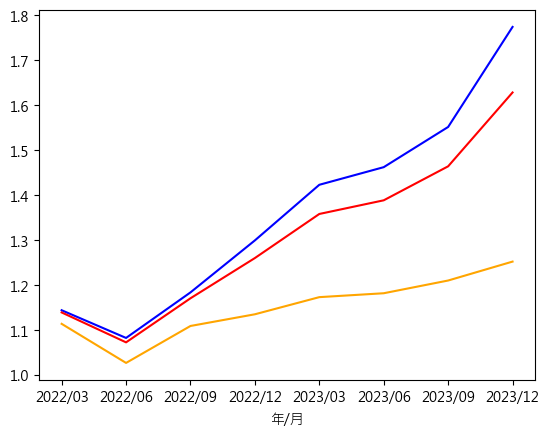

In [22]:
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']  #顯示中文
(test_data[selected].groupby('年/月').mean()['報酬率'] + 1).cumprod().plot(color = 'blue')     # 隨機森林的選股

(test_data[~selected].groupby('年/月').mean()['報酬率'] + 1).cumprod().plot(color = 'orange')  # 隨機森林沒有選到的股票

(test_data.groupby('年/月').mean()['報酬率'] + 1).cumprod().plot(color = 'red')                # 全買的結果

#### Step6.進行特徵選取，找出比較有用的特徵

In [23]:
#看權重, 看那些特徵比較重要
feature_name = train_data.columns[:-1]
important = pd.Series(rf.feature_importances_, index = feature_name).sort_values(ascending=False)
important.head(25)

ROE(A)－稅後              0.035115
每股盈餘                   0.028544
合併總損益                  0.027003
稅前純益 /實收資本             0.026956
繼續營業單位損益               0.024871
每股稅前淨利                 0.023790
歸屬母公司淨利（損）             0.023101
稅前淨利成長率                0.020524
ROE(B)－常續利益            0.019844
常續淨利成長率                0.019216
常續性稅後淨利                0.018709
稅前淨利                   0.018621
稅後淨利成長率                0.018291
  稅前淨利－CFO             0.016661
經常淨利成長率                0.016382
季底每股稅後淨利               0.015006
  後續可能重分類至損益之項目－OCI    0.012114
本期綜合損益總額               0.011769
ROE－綜合損益               0.011659
稅前淨利率                  0.011547
稅後淨利率                  0.011418
常續利益率－稅後               0.011268
營業利益成長率                0.010818
每股盈餘－完全稀釋              0.010548
綜合損益歸屬母公司              0.010038
dtype: float64

#### Step7.主觀挑選出比較好的特徵

In [24]:
#"主觀"挑選出值越高 越好的特徵
positive_features = ['稅前純益 /實收資本', 'ROE(A)－稅後','合併總損益','每股盈餘','每股稅前淨利','繼續營業單位損益','歸屬母公司淨利（損）','ROE(B)－常續利益','稅前淨利成長率','常續性稅後淨利','稅前淨利','常續淨利成長率','  稅前淨利－CFO','經常淨利成長率','稅後淨利成長率','ROE－綜合損益','稅前息前淨利','報酬率']

#### Step8.形成一個新的dataframe

In [25]:
merge2 = merge[positive_features]
merge2

稅前純益 /實收資本  ROE(A)－稅後    合併總損益  每股盈餘  每股稅前淨利  繼續營業單位損益  \
公司       年/月                                                               
1101 台泥  2013/03        6.34       1.39  1999624  0.38    0.63   1999624   
         2013/06       12.48       2.67  3802105  0.70    1.25   3802105   
         2013/09       17.65       3.76  5344662  0.97    1.77   5344662   
         2013/12       13.91       2.66  3972292  0.66    1.39   3972292   
         2014/03        9.62       1.79  2791235  0.50    0.96   2791235   
...                      ...        ...      ...   ...     ...       ...   
9958 世紀鋼 2022/12      -20.59      -3.70  -377681 -0.61   -2.06   -377681   
         2023/03       -0.20      -0.07    -7168  0.20   -0.02     -7168   
         2023/06       10.89       2.09   216606  0.99    1.09    216606   
         2023/09       23.85       3.97   434158  1.32    2.38    434158   
         2023/12       36.91       5.57   695846  1.95    3.71    695846   

                  歸屬母公司淨利（損）  ROE(B)－常續利益  稅前淨利成長率  常續性稅後淨利     稅前淨利  常續淨利成長率  \
公司       年/月                                                                    
1101 台泥  2013/03     1413035         1.06    -9.24  1523379  2340789   -16.72   
         2013/06     2586787         2.69    45.49  3829685  4608774    64.47   
         2013/09     3594193         3.78   106.30  5381893  6518421   104.46   
         2013/12     2432716         2.66    59.80  3978513  5136472    58.68   
         2014/03     1833139         1.70    51.69  2653386  3550846    74.18   
...                      ...          ...      ...      ...      ...      ...   
9958 世紀鋼 2022/12     -141438        -3.80  -326.89  -388319  -478494  -328.33   
         2023/03       47789        -0.18  -100.91   -18681    -4600  -104.77   
         2023/06      230844         1.98   549.26   205108   254037   366.82   
         2023/09      311763         3.73   186.86   408507   560722   214.04   
         2023/12      456221         5.61   282.02   701460   870974   280.64   

                    稅前淨利－CFO  經常淨利成長率  稅後淨利成長率  ROE－綜合損益     稅前息前淨利       報酬率  
公司       年/月                                                                   
1101 台泥  2013/03     2340789    -5.49    -5.49      2.29  2869049.0  0.027669  
         2013/06     4608774    34.86    34.86      1.81  5057115.0  0.056699  
         2013/09     6518421   108.95   108.95      4.76  6980865.0  0.032969  
         2013/12     5136472    58.56    58.56      5.76  5607727.0 -0.015218  
         2014/03     3550846    39.59    39.59      2.97  4033041.0  0.089381  
...                      ...      ...      ...       ...        ...       ...  
9958 世紀鋼 2022/12     -478494  -308.23  -308.23     -3.95  -402496.0  0.009249  
         2023/03       -4600  -101.78  -101.78     -0.09    74261.0  0.450962  
         2023/06      254037   427.91   427.91      2.13   359125.0  0.215421  
         2023/09      560722   207.22   207.22      4.05   660369.0  0.394740  
         2023/12      870974   284.24   284.24      5.90   964426.0  0.134703  

[45924 rows x 18 columns]

In [26]:
# 全部轉換成數值，Tej的數據有時候會有莫名的空格或是文字格式
merge2 = merge2.applymap(pd.to_numeric, errors='coerce')

# 使用條件來切分訓練集和測試集
condition = merge2.index.get_level_values('年/月').astype(str) < '202112'

# 有些地方，Tej沒有資料(是空格)，所以要補0
train_data2 = merge2[condition].fillna(0)
test_data2 = merge2[~condition].fillna(0)

C:\Users\joshchiang\AppData\Local\Temp\ipykernel_11832\3867612787.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  merge2 = merge2.applymap(pd.to_numeric, errors='coerce')


#### Step9.用新的特徵來跑模型

In [27]:
# 跑模型
rf1 = RandomForestClassifier(n_estimators=1000,max_depth=5,min_samples_leaf = 5,min_samples_split=20,criterion= 'entropy')
rf1.fit(train_data2.drop(columns = '報酬率'), train_data2['報酬率'] > 0)

RandomForestClassifier(criterion='entropy', max_depth=5, min_samples_leaf=5,
                       min_samples_split=10, n_estimators=1000)

In [28]:
#訓練集、測試集分數
print("訓練集分數: " , rf1.score(train_data2.drop(columns = '報酬率'), train_data2['報酬率'] > 0))
print("測試集分數: " , rf1.score(test_data2.drop(columns = '報酬率'), test_data2['報酬率'] > 0))

訓練集分數:  0.5948275862068966
測試集分數:  0.594563986409966


In [29]:
#回測
selected1 = rf1.predict(test_data2.drop(columns = '報酬率'))

<Axes: xlabel='年/月'>

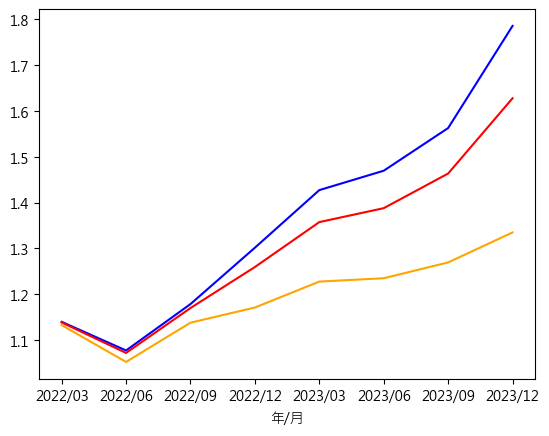

In [30]:
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']  #顯示中文
(test_data2[selected1].groupby('年/月').mean()['報酬率'] + 1).cumprod().plot(color = 'blue')     # 隨機森林的選股

(test_data2[~selected1].groupby('年/月').mean()['報酬率'] + 1).cumprod().plot(color = 'orange')  # 隨機森林沒有選到的股票

(test_data2.groupby('年/月').mean()['報酬率'] + 1).cumprod().plot(color = 'red')                # 全買的結果

#### Step10.找一棵樹畫出來看看

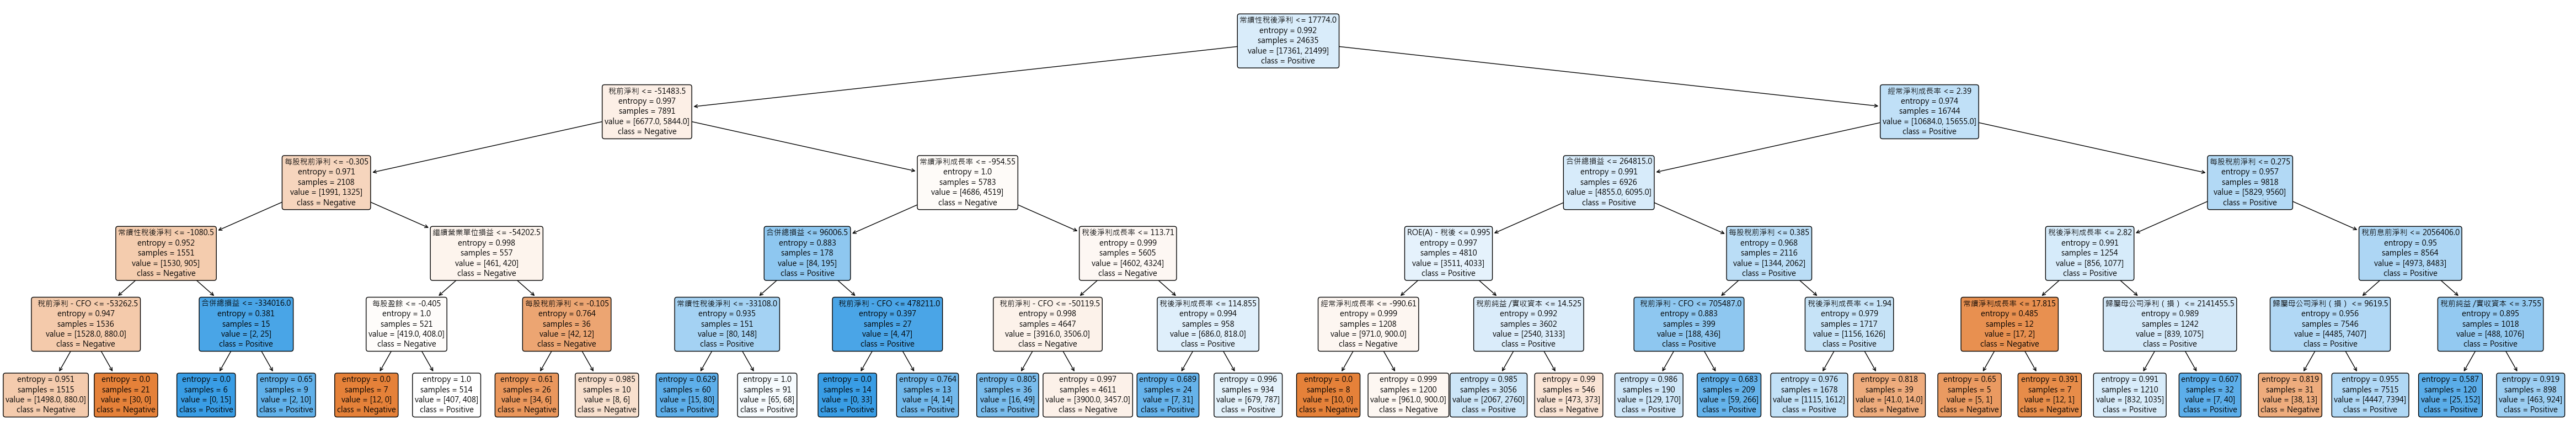

In [31]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# 使用隨機森林的其中一棵樹
estimator = rf1.estimators_[5]

# 畫出決策樹
plt.figure(figsize=(60, 10))
plot_tree(estimator, 
          feature_names=train_data2.drop(columns='報酬率').columns,
          class_names=['Negative', 'Positive'],
          filled=True, rounded=True, fontsize=10)
plt.show()